In [452]:
# this is a Jupyter R Notebook. 
# It can be edited and run in a browser
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.1                         
year           2019                        
month          07                          
day            05                          
svn rev        76782                       
language       R                           
version.string R version 3.6.1 (2019-07-05)
nickname       Action of the Toes          

## Intro

In [ ]:
# Code here replaces entire DCI R workflow pre-2020
# however, it requires barriers / junctions as nodes and segments as edges. 
# It uses two new output tables from FIPEX.
# FIPEX / ArcMap passes network data that includes nodes / junctions that are 
# branches in the river network (not just nodes that are barriers or sinks).
# DCIp, DCId, DCIs were all re-coded with alternatives benchmarked.
# Credit to Chris Edge (Natural Resources Canada) for DCId code that avoids loops in R.
# Please see accompanying Powerpoint for workflow diagrams. 
# - G Oldford, 2020

In [4]:
# required libraries
library(RBGL)
library(Rgraphviz)
library(rbenchmark)
library(data.table)
library(tidyverse)

# Jupyter R Notebooks can install packages required:
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

# new in 2020:
# (others may be used in experiemnts below but these are required as of 2020)
#install.packages("rbenchmark", repos='http://cran.us.r-project.org')
#install.packages("data.table", repos='http://cran.us.r-project.org')
#install.packages("tidyverse", repos='http://cran.us.r-project.org')

# Note 2020: 
# Some original files were modified to upgrade to newer version of R (3.6.1)
# variable names and functions with . were replaced with _ to avoid confusion 
# the visualization function 

In [9]:
# 'Advanced' table includes network edges and nodes
# with all original branch junctions in the GIS data 
# kept, even if they aren't barriers
# The 'advanced' table includes all info required to run DCI
# (previously two tables were required from FIPEX)
FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")

# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))
FIPEX_table

NodeEID,NodeLabel,HabQuantity,HabUnits,BarrierPerm,NaturalTF,DownstreamEID,DownstreamNodeLabel,DownstreamNeighDistance,DistanceUnits
<int>,<fct>,<dbl>,<fct>,<int>,<lgl>,<chr>,<fct>,<dbl>,<fct>
83,6,568.73,m,1,FALSE,sink,Sink,568.73,m
84,D,804.20,m,0,FALSE,83,6,804.20,m
96,7,973.69,m,1,FALSE,83,6,973.69,m
98,E,670.25,m,0,FALSE,84,D,670.25,m
94,A,1424.25,m,0,FALSE,96,7,1424.25,m
97,B,514.14,m,0,FALSE,96,7,514.14,m
99,F,698.75,m,0,FALSE,98,E,698.75,m
95,2,856.91,m,1,FALSE,94,A,856.91,m
100,C,1585.28,m,0,FALSE,97,B,1585.28,m


In [453]:
# The params file allows users to pass param settings
# to R from within the ArcMap software (new in 2020)
FIPEX_params=read.csv("FIPEX_2020_params.csv")
FIPEX_params

bDCISectional <- as.logical(FIPEX_params$bDCISectional)
bDistanceLim <- as.logical(FIPEX_params$bDistanceLim)
dMaxDist <- as.double(FIPEX_params$dMaxDist)
bDistanceDecay <- as.logical(FIPEX_params$bDistanceDecay)
sDDFunction <- as.character(FIPEX_params$sDDFunction)

bDCISectional,bDistanceLim,dMaxDist,bDistanceDecay,sDDFunction
<fct>,<fct>,<int>,<fct>,<fct>
True,True,1000,True,linear


# Functions

## function: create_basic_adjmatrix_2020

In [11]:
###### CREATE BASIC ADJACENCY MATRIX #####
# no edge weights, useful for DCI with no distance decay
# rbgl requires adjacency matrix 
# FIPEX outputs adjacency table so need to convert
# note: igraph requires only adjacency table

# library(rbenchmark) can be used to test
#https://stackoverflow.com/questions/34355892/build-a-square-adjacency-matrix-from-data-frame-or-data-tablelevs <- unique(unlist(neighbournodes_all, use.names=F))

create_basic_adjmatrix_2020 <- function(neighbournodes_all,option="2020_tapply") {
    # binary adjacency matrix defining connectivity
    
    if(option=="2020_tapply"){
        neighbournodes_all$edgeLength <- 1
        adj_matrix <- with(neighbournodes_all, tapply(edgeLength, list(Node1, Node2),FUN=length, default = 0))
        
    }else if(option=="2020_dfmatrix"){
        matrix_table <- table(neighbournodes_all)
        adj_mat1 <- as.data.frame.matrix(matrix_table)
        adj_matrix <- as.matrix(adj_mat1)
        
    }else if(option=="oldway"){
        
        # pre-2020 code
        segments<-with(neighbournodes_all, unique(Node2))
        #create a matrix with only 0's in them
        adj_matrix<-matrix(nrow=length(segments), 
                       ncol=length(segments), 
                       rep(0,length(segments)*length(segments)))
        segment_length<-length(segments)
        rownames(adj_matrix)<-colnames(adj_matrix)<-segments

        for (i in 1:segment_length){
            # find the segments in segment.matrix$Seg where segment.matrix$Seg_ID matches segments[i]
            # index of matching positions - this will be a vector of 1's and NA's
            pos_match<-	match(neighbournodes_all$Node2,segments[i])
        
            # keep only the positions where pos.match==1
            adj_segments<-neighbournodes_all$Node1[!is.na(pos_match)]

            # find the column positions that correspond to the adjacaent segments
            col<-match(adj_segments,segments)

            # the row number should correspond to i
            row<-i

            # assign a value of 1 for all values of row and col
            adj_matrix[row,col]<-1
        }
    }  
    adj_matrix
}

# check (need neighbournodes_all to check)
# dimensions should match
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_tapply"))
#dim(create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"))
#dim(create_adjmatrix_2020(neighbournodes_all,"oldway"))

In [13]:
totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)
print("For cross checks in GIS:")
print(totalhabitat)
print(totallength)

[1] "For cross checks in GIS:"
[1] 14887.19
[1] 14887.19


## function: create_advanced_adjmatrix_2020

In [19]:
################################################################
# edge-weighted connectivity list (edges_all) and matrix - for DCI w/ DD
# nodes / edges are not reversed as in original way
# do not need self-connected

create_advanced_adjmatrix_2020 <- function(FIPEX_table=NULL){

    # get connectivity list, convert columns to characters
    FIPEX_table_DD <- FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    mutate(temp = as.character(NodeEID)) %>%
    mutate(NodeEID = temp) %>%
    mutate(temp = as.character(DownstreamEID)) %>%
    mutate(DownstreamEID = temp) %>%
    select(-temp) %>%
    mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",DownstreamEID))

    # downstream neighbours
    edges_down <- FIPEX_table_DD

    # upstream neigbours
    edges_up <- FIPEX_table_DD %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    mutate(temp = DownstreamEID) %>%
    mutate(DownstreamEID = NodeEID) %>%
    mutate(NodeEID = temp) %>%
    select(-temp)

    # self-connected
    #FIPEX_table %>% select(NodeEID,DownstreamEID,DownstreamNeighDistance) %>%
    #mutate(NodeEID = DownstreamEID, DownstreamNeighDistance = 0.1)

    # merge
    edges_all <- edges_down %>%
    bind_rows(edges_up) %>%
    #add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
    rename(Node1 = NodeEID, Node2 = DownstreamEID, edgeLength = DownstreamNeighDistance)
    
    # convert to matrix
    adj_matrix_edgelengths <- with(edges_all, tapply(edgeLength, list(Node1, Node2), FUN=sum, default = 0))
    
    return(adj_matrix_edgelengths)
}

In [26]:
adj_matrix_edgelengths <- create_advanced_adjmatrix_2020(FIPEX_table)
adj_matrix_edgelengths

,100,101,102,83,84,94,95,96,97,98,99,sink
100,0.00,2335.07,0.00,0.00,0.00,0.00,0.00,0.00,1585.28,0.00,0.00,0.00
101,2335.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
102,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4455.92,0.00
83,0.00,0.00,0.00,0.00,804.20,0.00,0.00,973.69,0.00,0.00,0.00,568.73
84,0.00,0.00,0.00,804.20,0.00,0.00,0.00,0.00,0.00,670.25,0.00,0.00
94,0.00,0.00,0.00,0.00,0.00,0.00,856.91,1424.25,0.00,0.00,0.00,0.00
95,0.00,0.00,0.00,0.00,0.00,856.91,0.00,0.00,0.00,0.00,0.00,0.00
96,0.00,0.00,0.00,973.69,0.00,1424.25,0.00,0.00,514.14,0.00,0.00,0.00
97,1585.28,0.00,0.00,0.00,0.00,0.00,0.00,514.14,0.00,0.00,0.00,0.00
98,0.00,0.00,0.00,0.00,670.25,0.00,0.00,0.00,0.00,0.00,698.75,0.00


## Function: create_graph_dd_2020

In [ ]:
#to do: alternative graph creation using igraph
# benchmark
# note most code below assumes using an RGBL Boost GraphAM object,
#  so to test alternative it would require a lot of alternative code,
#  potentially

In [23]:
################################################################
# CREATE GRAPH OBJECT for DCI w/ Distance Decay
# edge weights are used for distance calculations
# edge data / attributes used for habitat quantity calculations
# #https://www.rdocumentation.org/packages/graph/versions/1.50.0/topics/graphAM-class
create_graph_dd_2020 <- function(adj_matrix_edgelengths=0.0,FIPEX_table=NULL){

    # Create graph object
    # 2020 - different way to call the graphAM function 
    # vs pre-2020
    g_dd <- graphAM(adjMat=adj_matrix_edgelengths,  edgemode="directed", values=list(weight=1))

    # associate passabilities with nodes using NodeData slot
    # e.g. nodeData(g,n=c("b", "c"), attr ="color") <- "red"
    nodeDataDefaults(g_dd, attr ="pass") <- 1.0
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="pass") <- as.double(FIPEX_table$BarrierPerm)
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="nodelabel") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="nodelabel") <- as.character(FIPEX_table$NodeLabel)
    nodeData(g_dd,n="sink", attr="nodelabel") <- "sink"
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="downnodelabel") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="downnodelabel") <- as.character(FIPEX_table$DownstreamNodeLabel)
    #nd <- nodes(g_dd)

    nodeDataDefaults(g_dd, attr ="natural") <- "none"
    nodeData(g_dd,n=as.character(FIPEX_table$NodeEID), attr="natural") <- FIPEX_table$NaturalTF
    nodeData(g_dd,n="sink", attr="natural") <- FALSE
    #nd <- nodes(g_dd)

    # optionally can give edges attributes
    #edgeDataDefaults(g_dd, attr="name")<-"noname"
    #edgeData(self, from, to, attr)
    #edgeData(self, from, to, attr) <- value
    edgeDataDefaults(g_dd, attr="HabitatQuan")<-0.0
    edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="HabitatQuan")<-as.double(FIPEX_table$HabQuantity)
    # reverse - attr associated with each direction along one edge
    edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="HabitatQuan")<-as.double(FIPEX_table$HabQuantity)


    # give edges an easy-to-access name insensitive to direction
    # this is done to quickly identify duplicates later
    # there may be alternatives such as accessing edgeNames but I suspect
    # they are slower than this
    edgeDataDefaults(g_dd, attr="EdgeNameGO")<-"init"
    edgeData(g_dd,from=as.character(FIPEX_table$NodeEID), 
         to=as.character(FIPEX_table$DownstreamEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")
    # reverse - attr associated with each direction along one edge
    edgeData(g_dd,from=as.character(FIPEX_table$DownstreamEID), 
         to=as.character(FIPEX_table$NodeEID), 
         attr="EdgeNameGO")<-paste(as.character(FIPEX_table$DownstreamEID),
                                   as.character(FIPEX_table$NodeEID),
                                   sep="-")
    return(g_dd)
}

In [27]:
g_dd<-create_graph_dd_2020(adj_matrix_edgelengths,FIPEX_table)

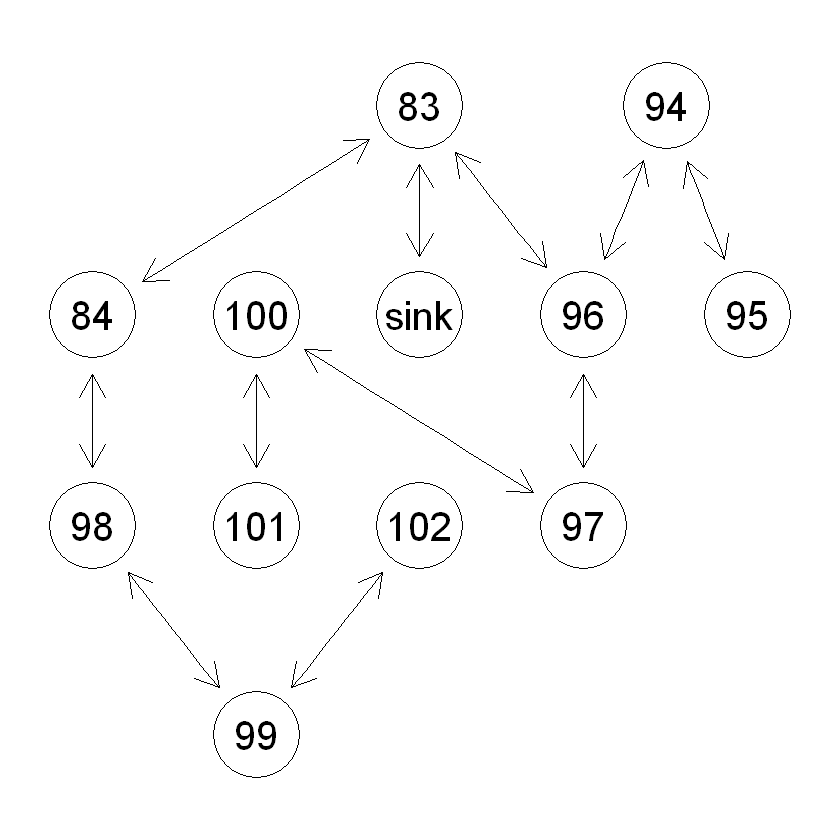

In [28]:
# Test visual with defaults

# note ignore the bidirectional arrows
# to do: add refined visuals function
library(Rgraphviz)

plot(g_dd)

## Function: get_paths_distances

In [30]:
################################################################################
# get all distances and paths (from penult) to all nodes from Sink / all nodes
# https://www.rdocumentation.org/packages/RBGL/versions/1.48.1/topics/dijkstra.sp
# note it must be node-node - no edge-edge possible
# note using this function repeatedly during DCIp is inefficient 
# !!! (should use BFS w/ LCA i.e., custom algorithm) !!!
#   (cannot edit the source for Djikstra.sp because it's actually an 
#   interface to C++ 'Boost'library for graphs - can't get edge and node attributes 
#   during net traversal)

get_paths_distances <- function(g=NULL,fromnode="sink"){
    dijkstra.sp(g,fromnode,eW=unlist(edgeWeights(g)))
    
    # TO DO: ALTERNATIVES FOR BENCHMARKING
}

In [68]:
# Example usage
paths_distances_sink <- get_paths_distances(g_dd,"sink")
paths_distances_sink$distances["100"]
# 3641.84 for test network

100 
3641.84

## Function: get_summary_tab_2020

In [161]:
##############################################################################
##### SUMMARY TABLE 2020 #####

# replaces similar pre-2020 function to create a table for each edge-edge pair
# Includes options for alternative data management for benchmarking
# (code could be trimmed).
# this function could be sped up with custom algorithm that can find path 
# while also grabbing attribute data (BFS w/ LCA). 
# - G Oldford, 2020

# gets cumulative passability each pair using path info
# and get other attributes

# pseudocode:
# for each 'from node' (e.g., sink in DCId, and all nodes in DCIp)
#  get paths between node and all other node
#
#  for each 'to node' in 'all paths' results
#   get the first edge len and hab traversed from node to sink
#
#   store length and hab of the edge between 'to node' and first node encountered
#   in path back to 'from node' (i.e., the 'to edge')

#   do while next node name <> "from node"
#     pass = nodeData(g_dd, nextnode, "pass")
#     cumulativepass =  cumulativepass * pass
#     nextnode = the next node in path towards 'from node'
#     if last edge traversed on the way to 'from node'
#       store the length and habitat of this edge which is the 'from edge'
#     if there is a maxdistance set for distance decay, 
#       add a TRUE/FALSE column to indicate this
#   
#   
#   add various other attributes to master table (attr's from g object)

# requires library(data.table)
# data.table vs other options likely to speed things up for large networks
#https://rstudio-pubs-static.s3.amazonaws.com/406521_7fc7b6c1dc374e9b8860e15a699d8bb0.html
#https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist

get_summary_tab_2020 <- function(option="dt-lists",
                                 naturalonly=FALSE,
                                 g = NULL,
                                 DCIp=FALSE,
                                 bDistanceLim=FALSE,
                                 dMaxDist=0.0){
    
    # funciton params:
    # option - for benchmarking speed of appending to table
    # naturalonly - will calculate pass-weighted path distances
    #  while ignoring non-natural barriers
    # g - the graph object (rbgl GraphAM in BioconductR)
    # DCIp - TRUE / FALSE will trigger loop that finds path
    #       between all nodes, node just sink
    # initialize empty data object in different ways
    
    # for different options and benchmarking:
    DT2 = data.table(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init")
    
    DF2 = data.frame(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 ToEdgeName="init",
                 FromEdgeName="init",
                 ToFromEdgeNameCombo="init", stringsAsFactors=F)
    
    # lists in R must have size pre-allocated 
    # size of our table is almost n^2 - n*(n-1) 
    # (less than n^2 since not getting distance from node to itself)
    if(DCIp==FALSE){
        outlist <- vector("list", length(numNodes(g_dd)))
    }else{
        outlist <- vector("list", length(numNodes(g_dd)*(numNodes(g_dd)-1)))   
    }
    
    outlist[[numNodes(g_dd)]] <- list(FromNode="init",
                 ToNode="init",
                 FromNodeLabel="init",
                 ToNodeLabel="init",
                 CumulativePass=0.0,
                 FromEdgeLen=0.0,
                 ToEdgeLen=0.0,
                 TotalDist=0.0,
                 DistMinusStartEndLen=0.0,
                 DistMinusSEExceedsThreshold=FALSE,
                 FromEdgeHab=0.0,
                 ToEdgeHab=0.0,
                 FromEdgeName="init",
                 ToEdgeName="init",
                 ToFromEdgeNameCombo="init")

    # from = sink / start node
    # to = other nodes
    if(DCIp==FALSE){
        fromnodecount=1
    }else{
        fromnodecount=numNodes(g_dd)
    }
    
    bDistMinusSEExceedsThreshold = FALSE
    count = 0
    for (j in 1:fromnodecount){
    #indendation for two nested for loops not done to save space
        if(DCIp==FALSE){
            fromnode_name = "sink"
            fromnode_label = "sink" 
        }else{
            fromnode_name = nodes(g_dd)[j]
             if (fromnode_name=="sink"){
                fromnode_label = "sink"
            }else{
                fromnode_label = nodeData(g_dd, fromnode_name, "nodelabel")[[1]]  
            }
        }
        
        ###########################################################
        #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # get path & distances between 'fromnode' and all other nodes
        paths_distances <- get_paths_distances(g,fromnode_name)
        # this can be time consuming
        
    for (k in 1:length(paths_distances$penult)) {
        
        tonode <- paths_distances$penult[k]     
        tonode_name = names(tonode)
        tonode_name <- tonode_name[[1]]
        tonode_label = nodeData(g_dd, tonode_name, "nodelabel")[[1]]
    
        if (tonode_name == fromnode_name){
            # not interested in distance from one node to itself
            next
        }
        count = count+1
        # initialize
        cumulativepass = 1.0
        pass = 1.0 # watch not to take pass from to/from end nodes since traversal starts at edge
        totaldistance = paths_distances$distances[tonode_name]
        totaldistance <- totaldistance[[1]]     
        
        # get length of edge 
        nextnode = paths_distances$penult[tonode]
        nextnode_name = names(nextnode)
        lastnode_name = tonode_name
    
        # get the last edge length traversed on the way to 'to node'
        # alternatively could grab the weight for this edge instead of subtraction
        toedgelen = totaldistance - paths_distances$distances[nextnode_name]
        toedgelen <- toedgelen[[1]]
        toedgedata =edgeData(g_dd, tonode_name,nextnode_name)
        toedgehab = toedgedata[[1]]$HabitatQuan
        toedgename = toedgedata[[1]]$EdgeNameGO
        
        exitvar = "go"
        while (exitvar != "stop"){
        
            if(nextnode_name != fromnode_name){
                pass = nodeData(g_dd, nextnode_name, "pass")
                if(naturalonly==FALSE){
                    cumulativepass = cumulativepass * pass[[1]]
                }else{
                    natural = nodeData(g_dd,nextnode_name,"natural")
                    if(natural[[1]]==TRUE){
                        cumulativepass = cumulativepass * pass[[1]]
                    }
                }
            }else{
                fromedgelen = paths_distances$distances[lastnode_name]
                fromedgelen <- fromedgelen[[1]]
                fromedgedata = edgeData(g_dd, lastnode_name,fromnode_name)
                fromedgehab = fromedgedata[[1]]$HabitatQuan
                fromedgename = fromedgedata[[1]]$EdgeNameGO
                
                exitvar="stop"
            }
            
            lastnode_name = nextnode_name
            nextnode = paths_distances$penult[nextnode]
            nextnode_name = names(nextnode)
        }
        
       distminusstartendlen = totaldistance - toedgelen - fromedgelen
       # less than zero distance indicates it's an edge-to-itself distance
       # correct for this
       if (distminusstartendlen<0){
          distminusstartendlen = 0 
       }
        
       tofromedgename_combo = paste(toedgename,fromedgename,sep="|")
       
       if (bDistanceLim == TRUE){
           if (distminusstartendlen > dMaxDist){
               bDistMinusSEExceedsThreshold=TRUE
           }else{
               bDistMinusSEExceedsThreshold=FALSE
           }
       }else{
           bDistMinusSEExceedsThreshold=FALSE
       }
       
        if (option=="dt"){
            #print(cumulativepass)
            #https://www.rdocumentation.org/packages/data.table/versions/1.13.0/topics/rbindlist
            DT1 = data.table(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHabLen=fromedgehablen,
                     ToEdgeHab=toedgehab,
                     FromEdgeHab=fromedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            l = list(DT1,DT2)
            
            DT2 = rbindlist(l, use.names=TRUE)
        }else if(option=="dt-lists"){
            # append lists to list rather than work yet with tables
            DL1 = list(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print("Length DL1: ")
            #print(length(DL1))
            outlist[[count]] <- (DL1)
            
        }else if(option=="df"){
            DF1 = data.frame(FromNode=fromnode_name,
                     ToNode=tonode_name,
                     FromNodeLabel=fromnode_label,
                     ToNodeLabel=tonode_label,
                     CumulativePass=cumulativepass, 
                     FromEdgeLen=fromedgelen,
                     ToEdgeLen=toedgelen,
                     TotalDist=totaldistance,
                     DistMinusStartEndLen=distminusstartendlen,
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(fromedgehabarea)
            #print(DF1)
            DF2 <- rbind(DF2, DF1)
          }else if(option=="df-lists"){
            DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=fromedgehab,
                     ToEdgeHab=toedgehab,
                     FromEdgeName=as.character(fromedgename),
                     ToEdgeName=as.character(toedgename),
                     ToFromEdgeNameCombo=as.character(tofromedgename_combo))
            outlist[[count]] <- (DL1)
        }else if(option=="dplyr"){
             DL1 = list(FromNode=as.character(fromnode_name),
                     ToNode=as.character(tonode_name),
                     FromNodeLabel=as.character(fromnode_label),
                     ToNodeLabel=as.character(tonode_label),
                     CumulativePass=as.numeric(cumulativepass), 
                     FromEdgeLen=as.numeric(fromedgelen),
                     ToEdgeLen=as.numeric(toedgelen),
                     TotalDist=as.numeric(totaldistance),
                     DistMinusStartEndLen=as.numeric(distminusstartendlen),
                     DistMinusSEExceedsThreshold = as.logical(bDistMinusSEExceedsThreshold),
                     FromEdgeHab=as.numeric(fromedgehab),
                     ToEdgeHab=as.numeric(toedgehab),
                     FromEdgeName=fromedgename,
                     ToEdgeName=toedgename,
                     ToFromEdgeNameCombo=tofromedgename_combo)
            #print(row1)
            DF2 <- bind_rows(DF2,DL1)
        }
    } #k
    } #j
        
    if(option=="dt"){
        sum_tab <- DT2
    }else if(option=="dt-lists"){
        DT2 <- data.table(rbindlist(outlist))
        
        sum_tab <- DT2
    }else if(option=="df"){
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        sum_tab <- DF2
    }else if(option=="df-lists"){
        DF2 <- data.frame(do.call(rbind, outlist))
        #DF2 <- DF2[!duplicated(DF2$ToFromEdgeNameCombo), ]
        sum_tab <- DF2
    }else if(option=="dplyr"){
        sum_tab <- DF2
    }
        
    # if a distance limit, eliminate rows
    if(bDistanceLim == TRUE){
        return(sum_tab[DistMinusSEExceedsThreshold==FALSE])
    }else{
        return(sum_tab) 
    } 
          
}


In [162]:
# example usage
# warning 'df-lists' does not work - it creates list type columns
#    which will cause errors in DCI calc!
sum_tab_2020 <- get_summary_tab_2020(option="dt-lists",
                                     naturalonly=FALSE,
                                     g = g_dd,
                                     DCIp=TRUE,
                                     bDistanceLim=TRUE,
                                     dMaxDist=1000
                                    )
sum_tab_2020 

FromNode,ToNode,FromNodeLabel,ToNodeLabel,CumulativePass,FromEdgeLen,ToEdgeLen,TotalDist,DistMinusStartEndLen,DistMinusSEExceedsThreshold,FromEdgeHab,ToEdgeHab,FromEdgeName,ToEdgeName,ToFromEdgeNameCombo
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
100,101,C,8,1,2335.07,2335.07,2335.07,0.00,FALSE,2335.07,2335.07,100-101,100-101,100-101|100-101
100,83,C,6,0,1585.28,973.69,3073.11,514.14,FALSE,1585.28,973.69,97-100,83-96,83-96|97-100
100,94,C,A,0,1585.28,1424.25,3523.67,514.14,FALSE,1585.28,1424.25,97-100,96-94,96-94|97-100
100,96,C,7,0,1585.28,514.14,2099.42,0.00,FALSE,1585.28,514.14,97-100,96-97,96-97|97-100
100,97,C,B,1,1585.28,1585.28,1585.28,0.00,FALSE,1585.28,1585.28,97-100,97-100,97-100|97-100
101,100,8,C,1,2335.07,2335.07,2335.07,0.00,FALSE,2335.07,2335.07,100-101,100-101,100-101|100-101
101,97,8,B,0,2335.07,1585.28,3920.35,0.00,FALSE,2335.07,1585.28,100-101,97-100,97-100|100-101
102,84,9,D,0,4455.92,670.25,5824.92,698.75,FALSE,4455.92,670.25,99-102,84-98,84-98|99-102
102,98,9,E,0,4455.92,698.75,5154.67,0.00,FALSE,4455.92,698.75,99-102,98-99,98-99|99-102


In [32]:
class(sum_tab_2020) # just a note data tables are both df and dt

[1] "data.table" "data.frame"

In [35]:
### benchmarking different approaches to summary table creation
# test with a large (1000's nodes) dataset 
library(rbenchmark)

benchmark(get_summary_tab_2020(option="dt",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dt-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="df-lists",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          get_summary_tab_2020(option="dplyr",
                     naturalonly=FALSE,
                     g = g_dd,
                     DCIp=TRUE),
          replications=40)
#dt-lists fastest

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,"get_summary_tab_2020(option = ""df-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,1.91,1.000,1.91,0.00,NA,NA
3,"get_summary_tab_2020(option = ""df"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,10.44,5.466,10.39,0.00,NA,NA
5,"get_summary_tab_2020(option = ""dplyr"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,2.25,1.178,2.25,0.00,NA,NA
2,"get_summary_tab_2020(option = ""dt-lists"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,1.92,1.005,1.91,0.02,NA,NA
1,"get_summary_tab_2020(option = ""dt"", naturalonly = FALSE, g = g_dd, DCIp = TRUE)",40,4.70,2.461,4.60,0.04,NA,NA


## Functions for DCI calculation

In [172]:
########################################################
###### Calculate DCI #####
#dci_calc_2020_dd <- function(){}
# warning: the sum_tab_2020 must be a data.table
#          only some data frames work ('dplyr' is ok not
#          the 'df-lists' option)


######### (1) DCId - calc_DCId #########
calc_DCId_2020 <- function(sum_tab_2020=NULL,
                           totalhabitat=0.0,
                           FromNode="sink",
                           bDistanceLim=FALSE){
    
    # filter table
    DCId_data<-subset(sum_tab_2020,FromNode=="sink")
    
    # Credit to Chris Edge Code for avoiding loops in R here: 
    if(bDistanceLim==FALSE){
        DCId_data$temp <- DCId_data$CumulativePass * (DCId_data$ToEdgeHab/totalhabitat)
    }else{
        DCId_data$temp <- DCId_data$CumulativePass * (DCId_data$ToEdgeHabMaxAccessible/DCId_data$MaxTotalAccessHabFromEdge)
    }
    DCId <- sum(DCId_data$temp)
    return(round(DCId*100,2))
} # DCId

######### (2) DCIp - calc_DCIp #########
# Credit to C Edge for shorter code
calc_DCIp_2020 <- function(sum_tab_2020=NULL,
                           totalhabitat=0.0,
                           option="unique",
                           bDistanceLim=FALSE){
    
    # 'option' = unique / distinct for benchmarking speeds
    # unique = data.table / base r
    # distinct = dplyr
    # to do: sometimes sum_tab may be a data.table sometimes data.frame
    if(option=="unique"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    }else{
        sum_tab_2020 <- distinct(sum_tab_2020, ToFromEdgeNameCombo, .keep_all = TRUE)
    }

    DCIp <- 0
    if(bDistanceLim==FALSE){
        for (i in 1:nrow(sum_tab_2020)) {
            DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$FromEdgeHab[i]/totalhabitat)) * (sum_tab_2020$ToEdgeHab[i]/totalhabitat)
        }
    }else{
        for (i in 1:nrow(sum_tab_2020)) {
            DCIp <- DCIp + (sum_tab_2020$CumulativePass[i] * (sum_tab_2020$FromEdgeHab[i]/totalhabitat))* (sum_tab_2020$ToEdgeHabMaxAccessible[i]/sum_tab_2020$MaxTotalAccessHabFromEdge[i]) 
        }
    }
    return(round(DCIp*100,2))
}

######### (3) DCIs - calc_DCIs #########
# can be added into (2) as option see below
calc_DCIs_2020 <- function (sum_tab_2020=NULL,
                            totalhabitat=0.0,
                            option="dt",
                            bDistanceLim=FALSE){
    
    # option: "dt","dplyr","old"
    # alternative methods for benchmarking
    if(option=="dt"){
        
        DCIs <- sum_tab_2020
        # remove duplicates
        DCIs <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
        
        if(bDistanceLim==FALSE){
            # select only a required columns
            cols = c("FromEdgeName","ToEdgeHab","CumulativePass")
            DCIs <- DCIs[,..cols]
            # first step to DCIs
            DCIs[, DCIs_i := round(ToEdgeHab/totalhabitat * CumulativePass * 100,2)]
        }else{
            # select only a required columns
            cols = c("FromEdgeName","ToEdgeHabMaxAccessible","CumulativePass","MaxTotalAccessHabFromEdge")
            DCIs <- DCIs[,..cols]
            # first step to DCIs
            DCIs[, DCIs_i := round(ToEdgeHabMaxAccessible/MaxTotalAccessHabFromEdge * CumulativePass * 100,2)]
        }
        
        cols = c("FromEdgeName","DCIs_i")
        DCIs <- DCIs[,..cols]
        # second step to DCIs
        DCIs <- DCIs[, lapply(.SD,sum), by=.(FromEdgeName)]
        
    }else if(option=="dplyr"){
        
        if(bDistanceLim==FALSE){
            DCIs <- sum_tab_2020 %>%
            distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
            mutate(DCIs_i = CumulativePass * ToEdgeHab/totalhabitat * 100) %>%
            select(DCIs_i,FromEdgeName) %>%
            group_by(FromEdgeName) %>%
            summarise(DCIs = sum(DCIs_i))
        }else{
            DCIs <- sum_tab_2020 %>%
            distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
            mutate(DCIs_i = CumulativePass * ToEdgeHabMaxAccessible/MaxTotalAccessHabFromEdge)*100 %>%
            select(DCIs_i,FromEdgeName) %>%
            group_by(FromEdgeName) %>%
            summarise(DCIs = sum(DCIs_i))
        }
        
        
    }else if(option=="old"){
        sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
        sections<-as.vector(unique(sum_tab_2020$FromEdgeName))
        # store the all section results in DCI.as
        DCI_as<-NULL
        
        for(s in 1:length(sections)){
            DCI_s<-0
            # Old notes:
            # select out only the data that corresponds to pathways from one sectino 
            # to all other sections
            d_nrows<-subset(sum_tab_2020, FromEdgeName==sections[s])
            d_sum_table<-d_nrows
            
            if(bDistanceLim==FALSE){
                for (a in 1:dim(d_nrows)[1]){
                    # Old note:
                    #to get the DCI for diadromous fish, use the following formula: 
                    # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                    la<-d_sum_table$ToEdgeHab[a]/sum(FIPEX_table$HabQuantity)
                    pass_d<-d_sum_table$CumulativePass[a]
                    DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
                } # end loop over sections for dci calc
            }else{
                for (a in 1:dim(d_nrows)[1]){
                    # Old note:
                    #to get the DCI for diadromous fish, use the following formula: 
                    # DCId= li/L*Cj (where j= the product of the passability in the pathway)
                    la<-d_sum_table$ToEdgeHabMaxAccessible[a]/d_sum_table$MaxTotalAccessHabFromEdge
                    pass_d<-d_sum_table$CumulativePass[a]
                    DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
                } # end loop over sections for dci calc
            }
            DCI_as[s]<-round(DCI_s*100,2)
        } # end loop over "first" sections	

        # STORE RESULTS IN .CSV file
        DCIs<-data.frame(sections,DCI_as)
    }else{
        print("error in options passed to calc_DCIs")
        DCIs <- 0.0
    }
    return(DCIs)
}

In [173]:
#example usage
calc_DCId_2020(sum_tab_2020,totalhabitat,"sink",FALSE)
calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique",FALSE)
calc_DCIs_2020(sum_tab_2020,totalhabitat,"dt",FALSE)

[1] 28.78

[1] 21.59

FromEdgeName,DCIs_i
<chr>,<dbl>
100-101,15.69
97-100,10.65
99-102,29.93
83-96,28.78
83-84,28.78
sink-83,28.78
84-98,4.50
96-94,28.78
94-95,5.76


In [40]:
# 
library(rbenchmark)

benchmark(calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique"),
          calc_DCIp_2020(sum_tab_2020,totalhabitat,"distinct"),
          replications=1000)
# unique is faster (data.table) vs distinct (dplyr)

,test,replications,elapsed,relative,user.self,sys.self,user.child,sys.child
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,"calc_DCIp_2020(sum_tab_2020, ""distinct"")",1000,1.22,1.184,1.22,0.00,NA,NA
1,"calc_DCIp_2020(sum_tab_2020, ""unique"")",1000,1.03,1.000,0.83,0.15,NA,NA


## Function: apply_distance_limits

In [419]:
apply_distance_limits <- function(sum_tab_2020 = NULL, 
                                bDistanceLim=FALSE, 
                                dMaxDist=0.0,
                                bDistanceDecay=FALSE,
                                sDDFunction="none"){
    
    # calculate proportion of 'to edge' within the max distance and multiply
    #sum_tab_2020 <- sum_tab_2020 %>%
    #mutate(ToEdgeHabProp = (DistMinusStartEndLen+ToEdgeLen-dMaxDist)/ToEdgeLen) %>%
    #mutate(ToEdgeHabProp = ifelse(ToEdgeHabProp>=0,1-ToEdgeHabProp,1)) %>%
    #mutate(ToEdgeHabMaxAccessible = ToEdgeHabProp * ToEdgeHab) %>%
    #select(-ToEdgeHabProp)

    get_max_accessible <- function(DistMinusStartEndLen,ToEdgeLen,ToEdgeHab,dMaxDist){
        prop_accessible = (dMaxDist-DistMinusStartEndLen)/ToEdgeLen
        prop_accessible = ifelse(prop_accessible>0,prop_accessible,0)
        prop_accessible = ifelse(prop_accessible>1,1,prop_accessible)
        toedge_maxaccessible = prop_accessible * ToEdgeHab
        toedge_maxaccessible
    }

    sum_tab_2020[, ToEdgeHabMaxAccessible := get_max_accessible(DistMinusStartEndLen,
                                                                ToEdgeLen,ToEdgeHab,dMaxDist)]
    

    
    if(bDistanceDecay==TRUE & sDDFunction!="none"){
        sum_tab_2020 <- apply_distance_decay(sum_tab_2020,sDDFunction,dMaxDist)
        # overwriting here because totals below should be based on weighted hab
        sum_tab_2020$ToEdgeHabMaxAccessible = sum_tab_2020$toedgehabaccessible_dd
        print("success")
    }
    
    # sum habitat accessible from edge and add as attribute
    # in new column 
    # remove duplicates first...
        # to do: dplyr is slower than data.table - re-code and benchmark
    sum_tab_hab <- sum_tab_2020 %>% 
    distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
    group_by(FromEdgeName) %>%
    summarise(MaxTotalAccessHabFromEdge = sum(ToEdgeHabMaxAccessible))

    sum_tab_2020 <- sum_tab_2020 %>%
    left_join(sum_tab_hab, by = "FromEdgeName", copy=FALSE)
    
    return(data.table(sum_tab_2020))
}

## Function: apply_distance_decay

In [417]:
apply_distance_decay <- function(sum_tab_2020=NULL,
                              sDDFunction="none",
                              dMaxDist = 0.0){

# distance decay options: "linear" - linear (1-x), 
#                         "natexp1"- natural exponential #1 (general form: e^x), 
#                         "natexp2" - natural exponential #2 (general form: e^x^2), 
#                         "circle" - based on equation of circle ((1-x^2)^0.5)
#                         "sigmoid" - sigmoid (general form:1/(1+e^x)
# functions chosen because they can be integrated analytically.
# for analytical solutions see documentation. 
# general form modified so intercepts are (0,1),(1,0) - sometimes approximate
# G Oldford, 2020

# to do: data.tables with many columns don't perform well and melt() may 
#        help

########## General Formulas ##########
#  multiplies the 'maximum accessible habitat' at edge j by f_avg(a,b)
# (max accessible is pre-calculated earlier using cut-off value and distance of edge j from edge i)
# 
# avg value of a dd function:
# f_avg(a,b,f(x)) = 1/(b-a)*integral_a_to_b(f(x)dx)
#           represents average value of distance decay function f(x) between 
#           two positions, a and b, along total distance from end of edge i to maxdist
#           where a and b are positions from 0 to maxdist (maxdist is always
#           rescaled to 1. 
# 'a' - proportion of maxdist reached at start of edge j 
# 'b' - proportion of maxdist reached at end of edge j 
    e = exp(1)
    
########## LINEAR distance decay function ##########
# function: (1-x) where x is proportion of maxdist
# f_avg = ((1-b)+(1-a))/2 
# toedgehabaccessible_dd = f_avg(a,b)*ToEdgeHabMaxAccessible
    f_avg_linear <- function(a,b) {((1-b)+(1-a))/2}

########## natural exponential DD Function #1 ########## 
########## general form: (-e^x) ##########
# parameterized function: f(x) = 1-e^(5(x-5)) with zero intercepts (0,1),(1,0)
# integral of f(x) = F_int = x - e^(5(x-1))/5)
# f_avg(a,b,f(x)) = 1/(b-a)*(b - e^(5(b-1))/5 -(a - e^(5(a-1))/5))
    integral_fx_natexp1 <- function(x){x-e^(5*(x-1))/5}
    f_avg_natexp1 <- function(a,b) {(1/(b-a)*(integral_fx_natexp1(b)-integral_fx_natexp1(a)))}

########## natural exponential DD Function #2 ########## 
########## general form: -e^x^2 ##########
# parameterized function: f(x) = 2 - e^((x^2)*1/1.44)
# integral of f(x) = F_int = ((pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x
# f_avg(a,b,f(x)) = to do
    # Note complete - can't be done without special erfi function 
    erf <- function(x) 2 * pnorm(x * sqrt(2)) - 1
    integral_fx_natexp2 <- function(x){((pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x}

########## CIRCULAR DD Function ########## 
########## general form: (1-x^2)^0.5  ##########
# parameterized function: f(x) = (1-x^2)^0.5
# integral of f(x) = F_int = (asin(x)+x*(1-x^2)^0.5)/2
# f_avg(a,b,f(x)) = (asin(b)+b*(1-b^2)^0.5)/2 - (asin(a)+a*(1-a^2)^0.5)/2
    integral_fx_circle <- function(x){(asin(x)+x*(1-x^2)^0.5)/2}
    f_avg_circle <- function(a,b){((asin(b)+b*(1-b^2)^0.5)/2 - (asin(a)+a*(1-a^2)^0.5)/2)}


###### SIGMOID DD function ###### 
###### general form: 1/(e^x+1))######
# parameterized function: f(x) = 1/(e^(10(x*0.5)))+1
# integral f(x) = F_int = x - ln(e^10x+e^5)/10
# f_avg(a,b,f(x)) = 1/(b-a)*(b - ln(e^10b+e^5)/10- a - ln(e^10a+e^5)/10)
    integral_fx_sigmoid <- function(x){x - log(e^10*x+e^5)/10}
    f_avg_sigmoid <- function(a,b) {(1/(b-a)*(integral_fx_sigmoid(b)-integral_fx_sigmoid(a)))}

##### Calculate distance-decay weighted habitat accessible ######
##### (at each edge j from each each i)
    get_dd_habitat <- function(DistMinusStartEndLen,ToEdgeHabMaxAccessible,dMaxDist,sDDFunction){
        
        a = round(DistMinusStartEndLen/dMaxDist,2)
        b = round((DistMinusStartEndLen+ToEdgeHabMaxAccessible)/dMaxDist,2)
        
        a = ifelse(a<0,0,a)
        a = ifelse(a>1,1,a)
        b = ifelse(b<0,0,b)
        b = ifelse(b>1,1,b)
   
        if(sDDFunction=="linear"){
            toedgehab_dd <- ToEdgeHabMaxAccessible * f_avg_linear(a,b)
        }else if(sDDFunction=="natexp1"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_natexp1(a,b)
        }else if(sDDFunction=="natexp2"){
            # to do
        }else if(sDDFunction=="circle"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_circle(a,b)
        }else if(sDDFunction=="sigmoid"){
            toedgehab_dd <- ToEdgeHabMaxAccessible*f_avg_sigmoid(a,b)
        }
        toedgehab_dd
    }

    sum_tab_2020[, toedgehabaccessible_dd := round(get_dd_habitat(DistMinusStartEndLen,
                                                                   ToEdgeHabMaxAccessible,
                                                                   dMaxDist,
                                                                   sDDFunction),2)]
    return(sum_tab_2020)
    
}

In [298]:
# example use
sDDFunction = "sigmoid"
dMaxDist = 1000
sum_tab_2020 <- apply_distance_decay(sum_tab_2020,sDDFunction,dMaxDist)

In [299]:
sum_tab_2020 %>% select(ToFromEdgeNameCombo,toedgehabaccessible_dd)

ToFromEdgeNameCombo,toedgehabaccessible_dd
<chr>,<dbl>
100-101|100-101,499.33
83-96|97-100,419.73
96-94|97-100,419.73
96-97|97-100,76.64
97-100|97-100,499.33
100-101|100-101,499.33
97-100|100-101,499.33
84-98|99-102,265.72
98-99|99-102,234.29


# Run Code With Distance Decay Option:
-calls functions above

In [484]:
# required libraries
library(RBGL) 
library(data.table) 
library(tidyverse)
# RBGL and Rgraphviz must be installed via BioconductR
#install.packages("BiocManager")
#BiocManager::install("Rgraphviz")
#BiocManager::install("RBGL")

# optional libraries
library(Rgraphviz) # only needed for visuals
library(rbenchmark) 

########## 1) DATA PREP #########

# 'Advanced' table includes habitat, length, connectivity info in one table
FIPEX_table=read.csv("FIPEX_Advanced_DD_2020.csv")
# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))

# for testing only: natural TF set node 84 to natural barrier
#FIPEX_table[2,]$NaturalTF <- TRUE
#FIPEX_table

# The params file allows users to pass param settings
# to R from within the ArcMap software (new in 2020)
FIPEX_params=read.csv("FIPEX_2020_params.csv")

###### 2) PARAMETERIZATION #######

bDCISectional <- as.logical(FIPEX_params$bDCISectional)
bDistanceLim <- as.logical(FIPEX_params$bDistanceLim)
dMaxDist <- as.double(FIPEX_params$dMaxDist)
bDistanceDecay <- as.logical(FIPEX_params$bDistanceDecay)
sDDFunction <- as.character(FIPEX_params$sDDFunction)
# for testing:
#sDDFunction = "linear"
#sDDFunction = "natexp1"
#sDDFunction = "circle"
#sDDFunction = "sigmoid"
#sDDFunction = "none"
bDistanceLim = FALSE
#dMaxDist = 1000
#bDistanceDecay = TRUE
#naturalonly = FALSE
#bDCISectional = TRUE
bDCIp = TRUE

totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)

######### 3) NETWORK ANALYSIS #########

# build adjacency matrix
edgeweighted_adj_matrix <- create_advanced_adjmatrix_2020(FIPEX_table)

# build graph object
g_dd <- create_graph_dd_2020(edgeweighted_adj_matrix,FIPEX_table)

# build summary table (analyses to determine paths, pass, etc between edges)
sum_tab_2020 <- get_summary_tab_2020(option="dt-lists",
                                     naturalonly,
                                     g_dd,
                                     bDCIp,
                                     bDistanceLim,
                                     dMaxDist)

if(bDistanceLim==TRUE){
    sum_tab_2020 <- apply_distance_limits(sum_tab_2020, bDistanceLim, dMaxDist, bDistanceDecay, sDDFunction)
}

# for testing: turn all pass = 1 and DCI should = 1
#sum_tab_2020<- sum_tab_2020 %>% mutate(CumulativePass=1)
#sum_tab_2020 = as.data.table(sum_tab_2020)

######## 4) DCI CALC ########
DCId = 0.00
DCIp = 0.00

DCId <- calc_DCId_2020(sum_tab_2020,totalhabitat,"sink",bDistanceLim)
DCIp <- calc_DCIp_2020(sum_tab_2020,totalhabitat,"unique",bDistanceLim)
if(bDCISectional==TRUE){
    DCIs <- calc_DCIs_2020(sum_tab_2020,totalhabitat,"dt",bDistanceLim)
}


######## 5) Write to Files ######

# following previous output format
res<- data.frame(c(DCIp,DCId))
names(res)<-"value"
row.names(res)<-c("DCIp","DCId")
write.table(res,file='out_dd.txt')

# 
# DCIs 'FromEdgeName' 100-101 has first numbers as downstream node
# to align in FIPEX it can be adjusted to e.g., 100_s
names(DCIs)[names(DCIs) == 'DCIs_i'] <- 'DCI_as'
names(DCIs)[names(DCIs) == 'FromEdgeName'] <- 'section'
DCIs$sections <- paste(sub("\\-.*", "", DCIs$section),"_s",sep="")
DCIs$sections[DCIs$sections == "sink_s"] <- "sink"
DCIs <- DCIs %>% select(sections,DCI_as)

res<-data.frame(DCIs)
write.table(x=res,
        file="DCI_all_sections_dd.csv",
            sep=",",
            row.names=F)

DCIp
DCId
DCIs

[1] 21.59

[1] 28.78

sections,DCI_as
<chr>,<dbl>
100_s,15.69
97_s,10.65
99_s,29.93
83_s,28.78
83_s,28.78
sink,28.78
84_s,4.50
96_s,28.78
94_s,5.76


In [ ]:
# correct output for DCIs from FIPEX for test network
83_s	28.78
84_s	4.5
96_s	28.78
98_s	4.69
94_s	5.76
97_s	10.65
99_s	29.93
95_s	5.76
100_s	15.69
102_s	29.93
101_s	15.69
sink	28.78

In [ ]:
# 
library(rbenchmark)

benchmark(
          replications=30)
# unique is faster (data.table) vs distinct (dplyr)

## Code below redundant - testing and benchmarking

In [449]:
# benchmarking and crosschecking - I tested three or four ways of calculating DCI_s. 
# no distance decay here 
# pre-2020 was very slow, data.table fastest as expected

calc_DCIs_dplyr <- function(sum_tab_2020=NULL,totalhabitat=NULL){
    
    DCIs <- sum_tab_2020 %>%
    distinct(ToFromEdgeNameCombo, .keep_all = TRUE) %>%
    mutate(DCIs_i = CumulativePass * ToEdgeHab/totalhabitat) %>%
    select(DCIs_i,FromEdgeName) %>%
    group_by(FromEdgeName) %>%
    summarise(DCIs = sum(DCIs_i))

    DCIs
}

calc_DCIs_dt <- function(sum_tab_2020=NULL,totalhabitat=NULL){
    
    DCIs <- sum_tab_2020
    # remove duplicates
    DCIs <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    # select only a required columns
    cols = c("FromEdgeName","ToEdgeHab","CumulativePass")
    DCIs <- DCIs[,..cols]
    # first step to DCIs
    DCIs[, DCIs_i := (ToEdgeHab/totalhabitat * CumulativePass)]
    cols = c("FromEdgeName","DCIs_i")
    DCIs <- DCIs[,..cols]
    # second step to DCIs
    DCIs[, lapply(.SD,sum), by=.(FromEdgeName)]

}

calc_DCIs_old <- function(sum_tab_2020=NULL,totalhabitat=NULL){

    sum_tab_2020 <- unique(sum_tab_2020, by = "ToFromEdgeNameCombo")
    sections<-as.vector(unique(sum_tab_2020$FromEdgeName))
    # store the all section results in DCI.as
    DCI_as<-NULL
        
    for(s in 1:length(sections)){
        DCI_s<-0
        # Old notes:
        # select out only the data that corresponds to pathways from one sectino 
        # to all other sections
        d_nrows<-subset(sum_tab_2020, FromEdgeName==sections[s])
        d_sum_table<-d_nrows
            
        for (a in 1:dim(d_nrows)[1]){
            # Old note:
            #to get the DCI for diadromous fish, use the following formula: 
            # DCId= li/L*Cj (where j= the product of the passability in the pathway)
            la<-d_sum_table$ToEdgeHab[a]/sum(FIPEX_table$HabQuantity)
            pass_d<-d_sum_table$CumulativePass[a]
            DCI_s<-round(DCI_s+la*pass_d*100, digits=2)
        } # end loop over sections for dci calc
        
        DCI_as[s]<-DCI_s
    } # end loop over "first" sections	

    # STORE RESULTS IN .CSV file
    res<-data.frame(sections,DCI_as)
    res
}


# cross check new way / old way of DCIs
calc_DCIs_dplyr(sum_tab_2020,totalhabitat)
calc_DCIs_dt(sum_tab_2020,totalhabitat)
calc_DCIs_old(sum_tab_2020,totalhabitat)

FromEdgeName,DCIs
<chr>,<dbl>
100-101,0.2633371
83-84,0.3797903
83-96,0.4393401
84-98,0.5488974
94-95,0.1532297
96-94,0.4518784
96-97,0.3943182
97-100,0.4589469
98-99,0.4452902


FromEdgeName,DCIs_i
<chr>,<dbl>
100-101,0.2633371
97-100,0.4589469
99-102,0.3912706
83-96,0.4393401
83-84,0.3797903
sink-83,0.3328540
84-98,0.5488974
96-94,0.4518784
94-95,0.1532297


sections,DCI_as
<fct>,<dbl>
100-101,26.34
97-100,45.90
99-102,39.12
83-96,43.93
83-84,37.97
sink-83,33.28
84-98,54.88
96-94,45.19
94-95,15.33


In [ ]:
# crosscheck DCIp (this is old way of calculating)
# summary tab csv must be based on same network config!
OLD_table=read.csv("summary_table_all.csv")

DCIp <- 0
for (i in 1:nrow(OLD_table)) {
    DCIp <- DCIp + (OLD_table$pathway_pass[i] * (OLD_table$start_section_length[i]/totalhabitatlength) * (OLD_table$finish_section_length[i]/totalhabitatlength))
}
print(DCIp)
#totalhabitatlength
#OLD_table$start_section_lengt

In [447]:
#outputDCI = list(("value"),("DCIp " & DCIp), ("DCId " & DCId))

res<- data.frame(c(DCIp,DCId))
names(res)<-"value"
row.names(res)<-c("DCIp","DCId")


,value
,<dbl>
DCIp,100
DCId,100


In [440]:
# 
library(rbenchmark)

benchmark(calc_DCIs_dplyr(sum_tab_2020,totalhabitatlength),
          calc_DCIs_dt(sum_tab_2020,totalhabitatlength),
          calc_DCIs_old(sum_tab_2020,totalhabitatlength),
          replications=30)
# unique is faster (data.table) vs distinct (dplyr)

[1] 100

### Experimental Section - connectivity list
#node oriented, for benchmarking only - next section has actual edge-oriented way accounting for length

In [ ]:
library(tidyverse)
library(data.table)

totalhabitat = sum(FIPEX_table$HabQuantity)
totallength = sum(FIPEX_table$DownstreamNeighDistance)

# ensure it's "sink" not "Sink"
FIPEX_table <- FIPEX_table %>%
mutate(DownstreamEID = ifelse(DownstreamEID == "Sink","sink",as.character(DownstreamEID)))

# get connectivity info only and convert columns to character,
FIPEX_table_reg <- FIPEX_table %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = as.character(NodeEID)) %>%
mutate(NodeEID = temp) %>%
mutate(temp = as.character(DownstreamEID)) %>%
mutate(DownstreamEID = temp) %>%
select(-temp) 

# produce connectivity table (node and neighbour node pairs)
# downstream neighbours
neighbournodes_down <- FIPEX_table_reg

# self-connected
neighbournodes_self <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(DownstreamEID = NodeEID)

# upstream neigbours
neighbournodes_up <- FIPEX_table_reg %>% select(NodeEID,DownstreamEID) %>%
mutate(temp = DownstreamEID) %>%
mutate(DownstreamEID = NodeEID) %>%
mutate(NodeEID = temp) %>%
select(NodeEID, DownstreamEID)

# merge
neighbournodes_all <- neighbournodes_down %>% bind_rows(neighbournodes_self) %>%
bind_rows(neighbournodes_up) %>%
add_row(NodeEID = "sink", DownstreamEID = "sink") %>%
rename(Node1 = NodeEID, Node2 = DownstreamEID)
neighbournodes_all

In [ ]:
# benchmark ways of creating adjacency matrix
# using 'regular' (non-dd) way
library(rbenchmark)
benchmark(create_basic_adjmatrix_2020(neighbournodes_all,"2020_tapply"),
create_basic_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
create_basic_adjmatrix_2020(neighbournodes_all,"oldway"),
replications=1000)
# tapply fastest

In [ ]:
################################################################
# produce binary connectivity matrix - useful for regular DCI
# zeros on diagonals are for visualization

adj_mat_new <- create_basic_adjmatrix_2020(neighbournodes_all,"2020_tapply")
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"2020_dfmatrix"),
#adj_mat_new <- create_adjmatrix_2020(neighbournodes_all,"oldway"

# produce copy with zeros on diagonal for visuals
adj_matrix_zeros_on_diag<- adj_mat_new
# diag() is a core R function - GO
diag(adj_matrix_zeros_on_diag)<-0

In [217]:
i = sqrt(−1+0i)
x = 1
erf <- function(x) 2 * pnorm(x * sqrt(2)) - 1
((pi*i)^1/3 * erf(5*i*x/6))/5 + 2*x
#(pi*i)^1/3 * erf(5*i*x/6)) / 5 + 2*x

ERROR: Error in pnorm(x * sqrt(2)): Non-numeric argument to mathematical function


In [216]:
erf(1)

[1] 0.8427008

In [226]:
asin(0)

[1] 0

In [240]:
x=0.6
(asin(x)+x*(1-x^2)^0.5)/2

[1] 0.5617506

In [464]:
#DCIs
DCIs$temp <- sub("\\-.*", "", DCIs$FromEdgeName)
DCIs$sections <- paste(DCIs$temp,"_s")
DCIs

FromEdgeName,DCIs_i,temp,sections
<chr>,<dbl>,<chr>,<chr>
100-101,15.69,100,100 _s
97-100,10.65,97,97 _s
99-102,29.93,99,99 _s
83-96,28.78,83,83 _s
83-84,28.78,83,83 _s
sink-83,28.78,sink,sink _s
84-98,4.50,84,84 _s
96-94,28.78,96,96 _s
94-95,5.76,94,94 _s


In [480]:

names(DCIs)[names(DCIs) == 'DCIs_i'] <- 'DCI_as'
names(DCIs)[names(DCIs) == 'FromEdgeName'] <- 'section'
DCIs$sections <- paste(sub("\\-.*", "", DCIs$section),"_s")
DCIs <- DCIs %>% select(sections,DCI_as)
DCIs


sections,DCI_as
<chr>,<dbl>
100 _s,15.69
97 _s,10.65
99 _s,29.93
83 _s,28.78
83 _s,28.78
sink _s,28.78
84 _s,4.50
96 _s,28.78
94 _s,5.76
